In [2]:
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        #if not os.path.exists(filename):
        #    download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 784)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        #if not os.path.exists(filename):
        #    download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    script_dir=os.getcwd()
    rel_path="Input_data/"
    abs_path=os.path.join(script_dir,rel_path)
    X_train = load_mnist_images(abs_path+'train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels(abs_path+'train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images(abs_path+'t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels(abs_path+'t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

### Success rate on MNIST dataset without PCA

In [5]:
import numpy as np
import sys
import os

from matplotlib import pyplot as plt

%matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test=load_dataset()

X_train=X_train.reshape((50000,784))

from sklearn import svm

clf=svm.LinearSVC(dual=False)

clf.fit(X_train,y_train)

X_val=X_val.reshape((10000,784))

val_out=out=clf.predict(X_val)

validation_success=(10000-np.count_nonzero(val_out-y_val))/10000.0

In [6]:
validation_success

0.9206

In [7]:
X_test=X_test.reshape((10000,784))

test_out=clf.predict(X_test)

test_success=(10000-np.count_nonzero(test_out-y_test))/10000.0

In [8]:
test_success

0.9153

0.95944 0.99976 0.926


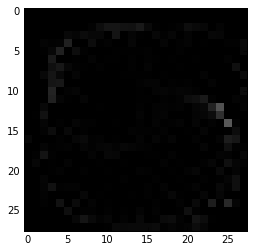

In [9]:
adv_examples=np.zeros((50000,784))

count_pure_adv=0.0
count_adv=0.0
count_wrong=0.0
print_flag=0
for i in range(50000):
    x_ini=(X_train[i,:]).reshape((1,784))
    ini_class=clf.predict(x_ini)
    x_adv=(x_ini-1.0*(clf.coef_[ini_class[0],:]/(np.linalg.norm(clf.coef_[ini_class[0],:])))).reshape((1,784))
    adv_examples[i,:]=x_adv
    final_class=clf.predict(x_adv)
    if ini_class[0]!=final_class[0]:
        count_adv=count_adv+1
    if y_train[i]!=final_class[0]:
        count_wrong=count_wrong+1
    if y_train[i]!=final_class[0] and ini_class[0]==y_train[i]:
        count_pure_adv=count_pure_adv+1
    if y_train[i]!=final_class[0] and ini_class[0]==y_train[i] and print_flag==0:
        #plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        plt.imshow(((x_adv-x_ini).reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        print_flag=print_flag+1
print count_wrong/50000.0, count_adv/50000.0, count_pure_adv/50000.0

In [10]:
for i in range(10):
    print np.linalg.norm(clf.coef_[i,:])

7.69510975284
10.8065906233
6.87037543784
7.14617459954
9.55690676778
8.80083475151
7.66908591272
8.65277752873
6.47265505265
8.49891874236


In [13]:
np.where(clf.coef_[0,:]>0.5)

(array([ 40,  44,  45, 146, 282, 311, 368, 503, 561, 614]),)

In [3]:
X_train_inc_adv=np.vstack((X_train,adv_examples))

NameError: name 'np' is not defined

In [9]:
y_train_new=np.hstack((y_train,y_train))

### Success rate on MNIST dataset with PCA

In [8]:
from sklearn.decomposition import PCA

rd=100

PCA_in_train=X_train.reshape(50000,784)
PCA_in_val=X_val.reshape(10000,784)
PCA_in_test=X_test.reshape(10000,784)

### Doing PCA over the training data
#Fitting the PCA model on training data
pca=PCA(n_components=rd)
pca_train=pca.fit(PCA_in_train)
#Transforming the training, validation and test data
X_train_dr=pca.transform(PCA_in_train).reshape((50000,rd))
X_test_dr=pca.transform(PCA_in_test).reshape((10000,rd))
X_val_dr=pca.transform(PCA_in_val).reshape((10000,rd))
X_adv_dr=pca.transform(adv_examples).reshape((50000,rd))

clf_pca=svm.LinearSVC(dual=False)

clf_pca.fit(X_train_dr,y_train)

val_out_pca=clf_pca.predict(X_val_dr)
validation_success_pca=(10000-np.count_nonzero(val_out_pca-y_val))/10000.0

In [9]:
validation_success_pca

0.9173

In [10]:
test_out_pca=clf_pca.predict(X_test_dr)

test_success_pca=(10000-np.count_nonzero(test_out_pca-y_test))/10000.0

In [11]:
test_success_pca

0.9124

In [34]:
count_pure_adv_pca=0.0
count_adv_pca=0.0
count_wrong_pca=0.0
#print_flag_pca=0
for i in range(50000):
    x_ini=(X_train_dr[i,:]).reshape((1,rd))
    ini_class=clf_pca.predict(x_ini)
    #x_adv=(x_ini-7.84*(clf_pca.coef_[ini_class[0],:]/(np.linalg.norm(clf_pca.coef_[0,:])))).reshape((1,rd))
    x_adv=X_adv_dr[i,:].reshape((1,rd))
    final_class=clf_pca.predict(x_adv)
    if ini_class[0]!=final_class[0]:
        count_adv_pca=count_adv_pca+1
    if y_train[i]!=final_class[0]:
        count_wrong_pca=count_wrong_pca+1
    if y_train[i]!=final_class[0] and ini_class[0]==y_train[i]:
        count_pure_adv_pca=count_pure_adv_pca+1
    #if y_train[i]!=final_class[0] and ini_class[0]==y_train[i] and print_flag==0:
        #plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        #plt.imshow(((x_adv-x_ini).reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        #print_flag=print_flag+1
print count_wrong_pca/50000.0, count_adv_pca/50000.0, count_pure_adv_pca/50000.0

0.09382 0.0041 0.00222


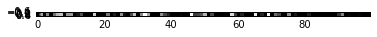

In [13]:
plt.imshow(x_ini*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

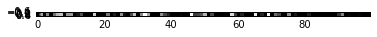

In [14]:
plt.imshow(X_train_dr[49999,:].reshape((1,rd))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

In [15]:
for i in range(10):
    print np.linalg.norm(clf_pca.coef_[i,:])

1.46482661704
2.4066516937
1.25262554342
1.2428049958
1.74251817407
1.5129434693
1.61626040866
1.82326830242
1.07849106658
1.62564372616


In [16]:
reverse_transform=pca.inverse_transform(X_train_dr[49999,:].reshape((1,rd)))

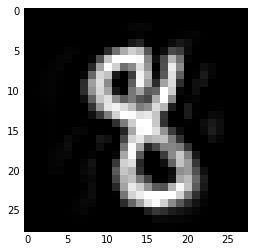

In [17]:
plt.imshow((reverse_transform.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

In [18]:
rev=pca.inverse_transform(x_ini)

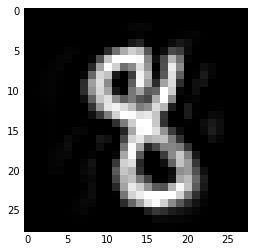

In [19]:
plt.imshow((rev.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

In [20]:
rev_ad=pca.inverse_transform(x_adv)

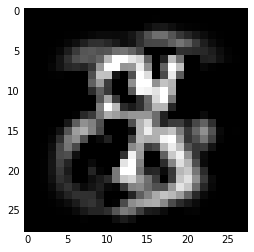

In [21]:
plt.imshow((rev_ad.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

In [22]:
rev_ad_2=pca.inverse_transform(x_adv)

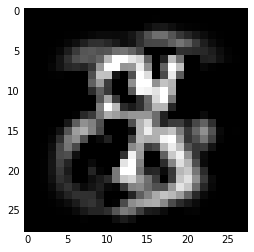

In [23]:
plt.imshow((rev_ad_2.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

### Random projections

In [24]:
from sklearn import random_projection

In [25]:
rand_transform=random_projection.GaussianRandomProjection(n_components=100)

In [26]:
X_train_rand_dr=rand_transform.fit_transform(X_train)

In [27]:
clf_rand_dr=svm.LinearSVC(dual=False)

In [28]:
clf_rand_dr.fit(X_train_rand_dr,y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [29]:
X_val_rand_dr=rand_transform.transform(X_val)
X_test_rand_dr=rand_transform.transform(X_test)

In [30]:
val_out_rand_dr=clf_rand_dr.predict(X_val_rand_dr)
validation_success_rand_dr=(10000-np.count_nonzero(val_out_rand_dr-y_val))/10000.0
validation_success_rand_dr

0.8919

In [31]:
test_out_rand_dr=clf_rand_dr.predict(X_test_rand_dr)
test_success_rand_dr=(10000-np.count_nonzero(test_out_rand_dr-y_test))/10000.0
test_success_rand_dr

0.887

In [32]:
count_pure_adv_rand_dr=0.0
count_adv_rand_dr=0.0
count_wrong_rand_dr=0.0
#print_flag_pca=0
for i in range(50000):
    x_ini=(X_train_rand_dr[i,:]).reshape((1,rd))
    ini_class=clf_rand_dr.predict(x_ini)
    #x_adv=(x_ini-31.36*(clf_pca.coef_[ini_class[0],:]/(np.linalg.norm(clf_pca.coef_[0,:])))).reshape((1,rd))
    x_adv=X_adv_dr[i,:].reshape((1,rd))
    final_class=clf_rand_dr.predict(x_adv)
    if ini_class[0]!=final_class[0]:
        count_adv_rand_dr=count_adv_rand_dr+1
    if y_train[i]!=final_class[0]:
        count_wrong_rand_dr=count_wrong_rand_dr+1
    if y_train[i]!=final_class[0] and ini_class[0]==y_train[i]:
        count_pure_adv_rand_dr=count_pure_adv_rand_dr+1
    #if y_train[i]!=final_class[0] and ini_class[0]==y_train[i] and print_flag==0:
        #plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        #plt.imshow(((x_adv-x_ini).reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        #print_flag=print_flag+1
print count_wrong_rand_dr/50000.0, count_adv_rand_dr/50000.0, count_pure_adv_rand_dr/50000.0

0.93642 0.93952 0.82838
